In [105]:
from model import baseline_resnet18

model = baseline_resnet18(pretrained=True).cuda()

In [103]:
data = torch.zeros((1, 3, 256, 256)).cuda()

In [106]:
cmap, paf = model(data)

In [138]:
from torchvision.datasets import CocoDetection


class CocoPersonDataset(CocoDetection):
    
    def __init__(self, *args, **kwargs):
        super(CocoPersonDataset, self).__init__(*args, **kwargs)
        self.ids = list(sorted(self.coco.getImgIds(catIds=self.coco.getCatIds('person'))))

train_dataset = CocoPersonDataset('train2017', 'annotations/person_keypoints_train2017.json')

loading annotations into memory...
Done (t=6.03s)
creating index...
index created!


In [136]:
self.coco.getImgIds(catIds=self.coco.getCatIds('person'))

64115

In [133]:
train_dataset.coco.getCatIds('person')

[1]

In [160]:
len(target[2]['keypoints'])/3

17.0

In [161]:
import matplotlib.pyplot as plt

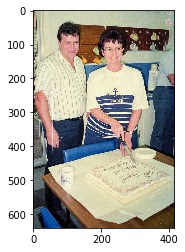

In [162]:
plt.imshow(image)
plt.plot()

In [166]:
target[0]['keypoints']

[115,
 110,
 2,
 127,
 97,
 2,
 101,
 99,
 2,
 0,
 0,
 0,
 77,
 96,
 2,
 134,
 152,
 2,
 47,
 163,
 2,
 184,
 258,
 1,
 19,
 260,
 2,
 237,
 291,
 1,
 48,
 354,
 2,
 137,
 327,
 2,
 74,
 339,
 2,
 125,
 457,
 1,
 65,
 467,
 1,
 139,
 573,
 1,
 63,
 583,
 1]

In [ ]:
# 0 - NOSE
# 1 - LEYE
# 2 - REYE
# 3 - LEAR
# 4 - REAR
# 5 - LSHOULDER
# 6 - RSHOULDER
# 7 - LELBOW
# 8 - RELBOW
# 9 - LWRIST
# 10 - RWRIST
# 11 - LHIP
# 12 - RHIP
# 13 - LKNEE
# 14 - RKNEE
# 15 - LANKLE
# 16 - RANKLE

In [231]:
from topology import PARTS, TOPOLOGY, COCO_PARTS

In [301]:
def convert_annotations(input_shape, annotations, topology):
    C = len(PARTS)
    K = topology.shape[0]
    M = 100
    IH = input_shape[0]
    IW = input_shape[1]
    counts = torch.zeros((C)).int()
    peaks = torch.zeros((C, M, 2)).float()
    visibles = torch.zeros((len(annotations), C)).int()
    connections = -torch.ones((K, 2, M)).int()
    
    for ann_idx, ann in enumerate(annotations):
        
        kps = ann['keypoints']
        
        # add visible peaks
        for c in range(C):
            
            if PARTS[c] == 'NECK':
                c_coco_l = COCO_PARTS.index('LSHOULDER')
                x_l = kps[c_coco_l*3]
                y_l = kps[c_coco_l*3+1]
                vis_l = kps[c_coco_l*3+2]
                c_coco_r = COCO_PARTS.index('RSHOULDER')
                x_r = kps[c_coco_r*3]
                y_r = kps[c_coco_r*3+1]
                vis_r = kps[c_coco_r*3+2]
                visible = vis_l and vis_r
                x = (x_l + x_r) / 2.0
                y = (y_l + y_r) / 2.0
            else:
                c_coco = COCO_PARTS.index(PARTS[c])
                x = kps[c_coco*3]
                y = kps[c_coco*3+1]
                visible = kps[c_coco*3 + 2]

            if visible:
                peaks[c][counts[c]][0] = (float(y) + 0.5) / IH
                peaks[c][counts[c]][1] = (float(x) + 0.5) / IW
                counts[c] = counts[c] + 1
                visibles[ann_idx][c] = 1
                
        for k in range(K):
            c_a = topology[k][2]
            c_b = topology[k][3]
            if visibles[ann_idx][c_a] and visibles[ann_idx][c_b]:
                connections[k][0][counts[c_a] - 1] = counts[c_b] - 1
                connections[k][1][counts[c_b] - 1] = counts[c_a] - 1
                
    return counts, peaks, connections

In [267]:
topology = torch.Tensor(TOPOLOGY).int()

In [460]:
peak_counts, peaks, connections = convert_annotations((image.height, image.width), target, topology)

In [461]:
peak_counts = peak_counts[None, ...]
peaks = peaks[None, ...]
connections = connections[None, ...]

In [298]:
import trt_pose.plugins

In [462]:
cmap = trt_pose.plugins.generate_cmap(peak_counts, peaks, 64, 64, 10, 30)
paf = trt_pose.plugins.generate_paf(connections, topology, peak_counts, peaks, 64, 64, 10)

In [463]:
infer_counts, infer_peaks = trt_pose.plugins.find_peaks(cmap, 0.1, 5, 100)
infer_refined_peaks = trt_pose.plugins.refine_peaks(infer_counts, infer_peaks, cmap, 5)
score_graph = trt_pose.plugins.paf_score_graph(paf, topology, infer_counts, infer_refined_peaks, 15)
infer_connections = trt_pose.plugins.assignment(score_graph, topology, infer_counts, -10.0)
num_objects, objects = trt_pose.plugins.connect_parts(infer_connections, topology, infer_counts, 100)

In [444]:
topology[12]

tensor([25, 24,  6,  7], dtype=torch.int32)

In [470]:
PARTS[topology[10][3]]

'LSHOULDER'

In [467]:
score_graph[0][10]

tensor([[ 1.0137, -0.5670,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7657,  1.0156,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [464]:
infer_cmap = trt_pose.plugins.generate_cmap(infer_counts, infer_refined_peaks, 64, 64, 10, 30)
infer_paf = trt_pose.plugins.generate_paf(infer_connections, topology, infer_counts, infer_refined_peaks, image.height, image.width, 10)

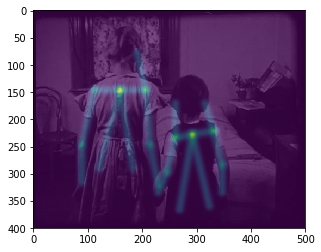

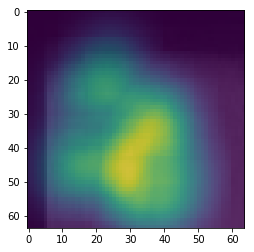

In [465]:
plt.imshow(image)
plt.imshow((infer_paf[0][0::2]**2 +infer_paf[0][1::2]**2).sum(0), alpha=0.7)
plt.show()
plt.imshow(image)
plt.imshow(cmap[0].sum(0), alpha=0.7)
plt.show()

[]

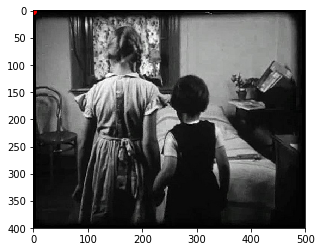

In [459]:
image, target = train_dataset[502]

kps = target[0]['keypoints']
idx = 16

plt.imshow(image)
plt.plot(kps[idx*3], kps[idx*3+1], 'ro')
plt.plot()

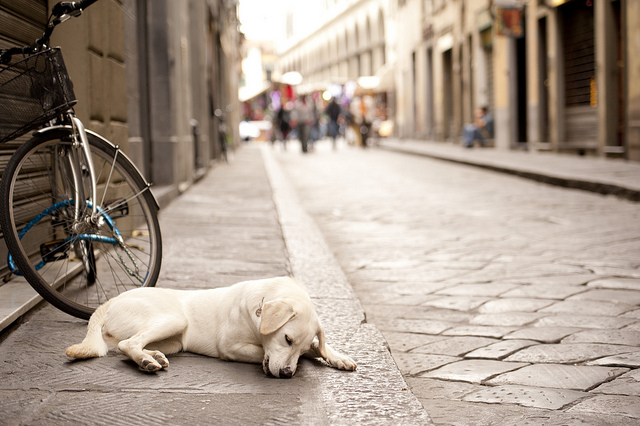

In [141]:
image